In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/My\ Drive/Colab-Works/dqn-MNIST

/content/drive/My Drive/Colab-Works/dqn-MNIST


In [3]:
!pwd

/content/drive/My Drive/Colab-Works/dqn-MNIST


## Current Status:
Paused working on it. Will use similar idea for easier problem statements first, statements like drawing shapes like line or rectangle.

## Goal:
To train a DQN to draw an MNIST digit on a blank canvas. <br>
As someone who has worked on GANs a lot, it struct to me that GANs generate images in one-shot, as opposed to humans, who draw in a sequential manner. Hence I try to use RL in order to experiment if DQN can generate/draw an MNIST digit by taking a sequence of steps on a blank canvas.


## References:
- https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
- https://github.com/pytorch/examples/blob/master/mnist/main.py

In [0]:
import numpy as np
import matplotlib.pyplot as plt

import gym
from gym import spaces

import torch
from torch import nn, optim
import torch.nn.functional as F

import os
import random
import math
from collections import namedtuple
from itertools import count

In [0]:
class RewardModel(nn.Module):
    def __init__(self):
        super(RewardModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [0]:
class CanvasEnv(gym.Env):
    def __init__(self, digit):
        super(CanvasEnv, self).__init__()
        self.digit = digit
        self.action_space = spaces.Discrete(6)
#         self.observation_space = spaces.Box(low=0, high=1, shape=(28, 28), dtype=int)
        
        self.canvas = np.zeros((28, 28))
        self.position_on_canvas = np.zeros((28, 28))
        self.old_canvas = self.canvas.copy()
        self.pen_down = False
        
        self.action_map = {
            0: "left",
            1: "up",
            2: "right",
            3: "bottom",
            4: "switch",
            5: "stop"
        }
        
        self.reward_model = RewardModel()
        self.reward_model.load_state_dict(torch.load("reward_model/model.pt"))
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.reward_model.double().to(self.device)
        self.reward_model.eval()
        
    def step(self, action):
        done = False
        beyond_limit = False
#         self.old_canvas = self.canvas.copy()
        
        
        self.position_on_canvas[self.x, self.y] = 0
        
        if self.action_map[action] == "left":
            if self.y == 0:
                beyond_limit = True
            self.y = max(0, self.y-1)
        elif self.action_map[action] == "right":
            if self.y == 27:
                beyond_limit = True
            self.y = min(27, self.y+1)
        elif self.action_map[action] == "up":
            if self.x == 0:
                beyond_limit = True
            self.x = max(0, self.x-1)
        elif self.action_map[action] == "down":
            if self.x == 27:
                beyond_limit = True
            self.x = min(27, self.x+1)
        elif self.action_map[action] == "switch":
            self.pen_down = not self.pen_down
        elif self.action_map[action] == "stop":
            done = True
            
        self.position_on_canvas[self.x, self.y] = 1
        if self.pen_down:
            self.canvas[self.x, self.y] = 1
        
        reward_model_input = torch.from_numpy(self.canvas).view(1, 1, 28, 28).double().to(self.device)
        reward_model_output = self.reward_model(reward_model_input)
        reward = torch.exp(reward_model_output.squeeze()[self.digit]).cpu().detach().numpy()
        reward = np.reshape(reward, (1,))
        reward[reward < 0.8] = 0
        # if np.sum(self.canvas - self.old_canvas) == 0:
        #     reward[0] = -1
        if beyond_limit:
            reward[0] = -1
        
        return self.as_tensor(np.concatenate([self.position_on_canvas, self.canvas])), reward, done
    
    def reset(self):
        self.canvas *= 0
        self.position_on_canvas *= 0
        self.x, self.y = random.randint(0, 27), random.randint(0, 27)
        self.pen_down = False
        self.position_on_canvas[self.x, self.y] = 1
#         self.old_canvas = self.canvas.copy()
        self.position_on_canvas[self.x, self.y] = 1
        return self.as_tensor(np.concatenate([self.position_on_canvas, self.canvas]))
    
    def render(self):
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(self.position_on_canvas)
        axarr[1].imshow(self.canvas)
        plt.show()
        
    def as_tensor(self, array):
        array = np.reshape(array, [1, 2, 28, 28])
        return torch.from_numpy(array).double().to(self.device)

In [0]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [0]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = list()
        self.position = 0
        
    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [0]:
class DQN(nn.Module):
    def __init__(self, nb_actions):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(2, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        self.conv4 = nn.Conv2d(64, 128, 3, 1)
        self.fc1 = nn.Linear(128*10*10, 4096)
        self.fc2 = nn.Linear(4096, 2048)
        self.fc3 = nn.Linear(2048, 1024)
        self.fc4 = nn.Linear(1024, nb_actions)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        # print(x.shape)
        # x = F.relu(x)
        # x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        # x = F.relu(x)
        # x = self.fc2(x)
        return x

In [0]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 1.0
EPS_END = 0.05
EPS_DECAY = 5000
TARGET_UPDATE = 10

DIGIT = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

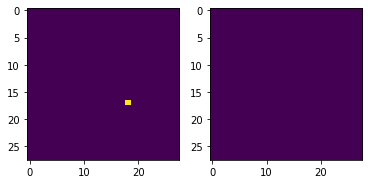

In [11]:
env = CanvasEnv(DIGIT)
env.reset()
env.render()

In [0]:
nb_actions = env.action_space.n

In [13]:
policy_net = DQN(nb_actions).double().to(device)
target_net = DQN(nb_actions).double().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DQN(
  (conv1): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=12800, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=6, bias=True)
)

In [0]:
optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

In [0]:
# steps_done = 0

def select_action(state, eps_threshold):
#     state = np.reshape(state, [1, 1, 28, 28])
#     state = torch.from_numpy(state).double().to(device)
    
    global steps_done
    sample = random.random()
    # eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    # print(eps_threshold)
    # steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1]
    else:
        return torch.tensor([random.randrange(nb_actions)], device=device, dtype=torch.long)

In [0]:
episode_durations = list()

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Eposide')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    plt.pause(0.001)

In [0]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        print("Not Enough Samples in Memory")
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
#     for a in batch.action:
#         print(a.shape)
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
#     print(policy_net(state_batch).shape, action_batch.shape)
    state_action_values = policy_net(state_batch).gather(1, action_batch.view(-1, 1))
    
    next_state_values = torch.zeros(BATCH_SIZE, device=device).double()
#     print(target_net(non_final_next_states).dtype, next_state_values.dtype, non_final_mask.dtype)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

Running Episode 1/100, Epsilon = 1.0
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory


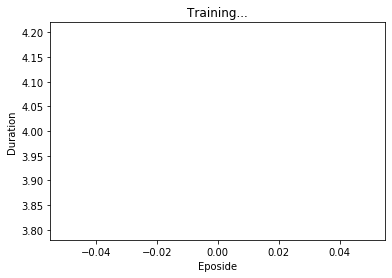

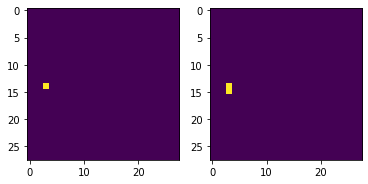

Running Episode 2/100, Epsilon = 1.0
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory


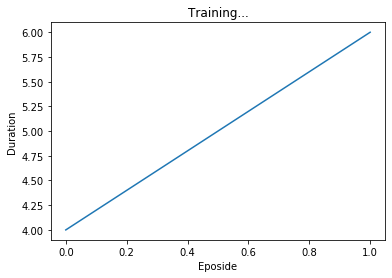

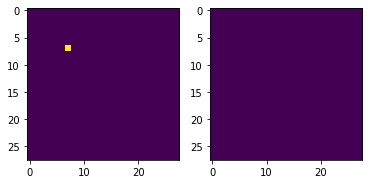

Running Episode 3/100, Epsilon = 1.0
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory


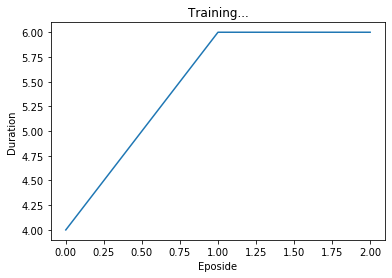

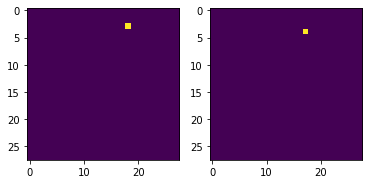

Running Episode 4/100, Epsilon = 1.0
Not Enough Samples in Memory
Not Enough Samples in Memory


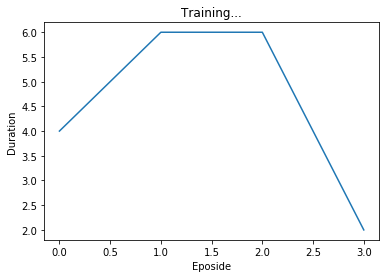

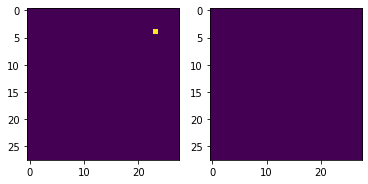

Running Episode 5/100, Epsilon = 1.0
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory


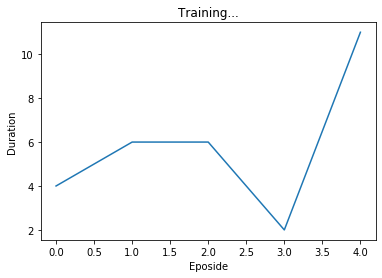

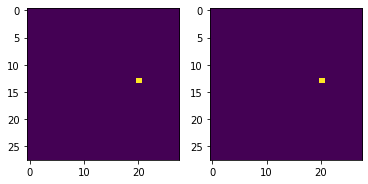

Running Episode 6/100, Epsilon = 1.0
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory


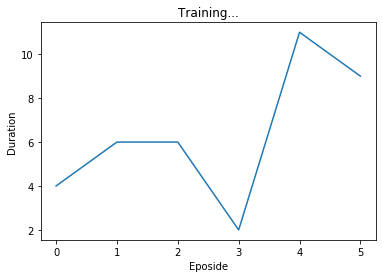

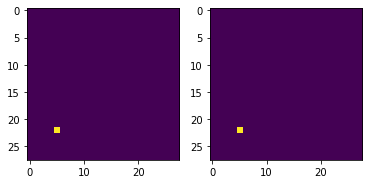

Running Episode 7/100, Epsilon = 1.0
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory


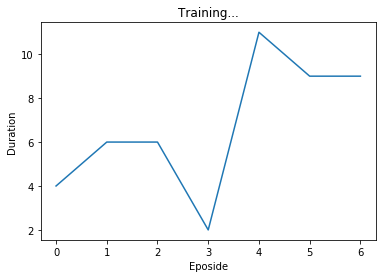

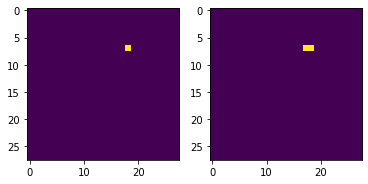

Running Episode 8/100, Epsilon = 1.0
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory


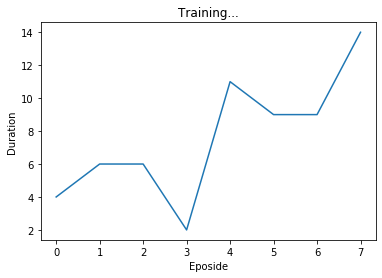

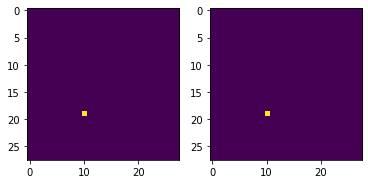

Running Episode 9/100, Epsilon = 1.0
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory


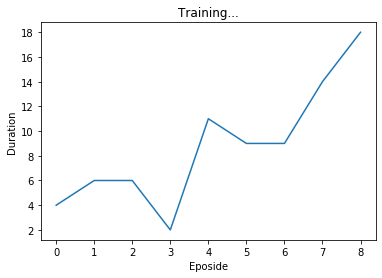

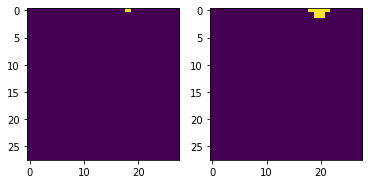

Running Episode 10/100, Epsilon = 0.99
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory


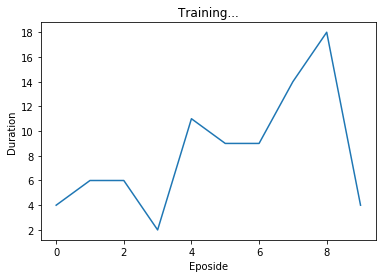

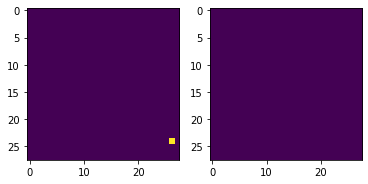

Running Episode 11/100, Epsilon = 0.99
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory


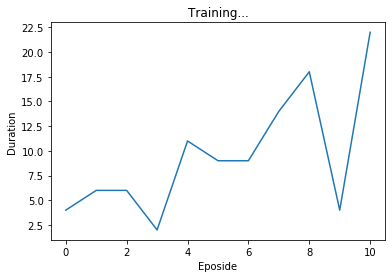

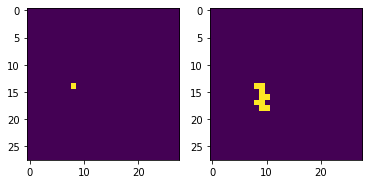

Running Episode 12/100, Epsilon = 0.99
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory


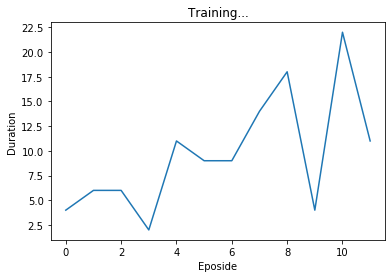

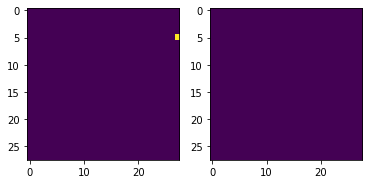

Running Episode 13/100, Epsilon = 0.99
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory
Not Enough Samples in Memory


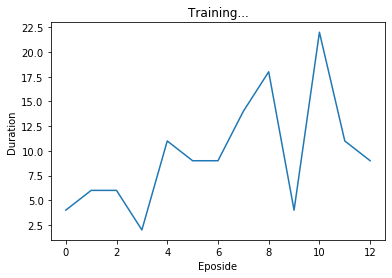

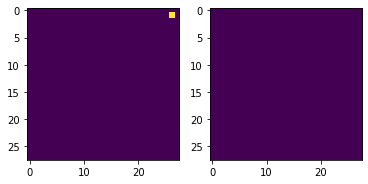

Running Episode 14/100, Epsilon = 0.99
Not Enough Samples in Memory
Not Enough Samples in Memory


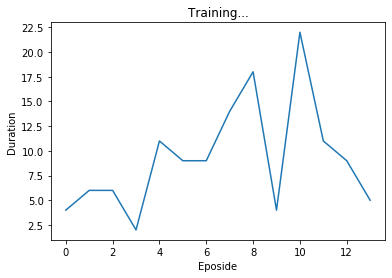

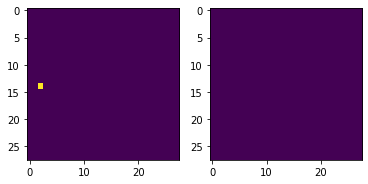

Running Episode 15/100, Epsilon = 0.99


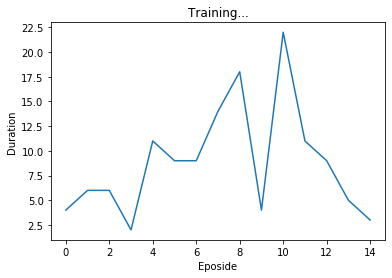

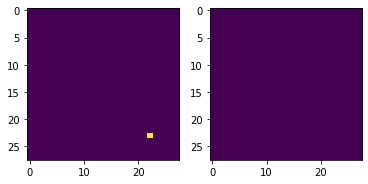

Running Episode 16/100, Epsilon = 0.99


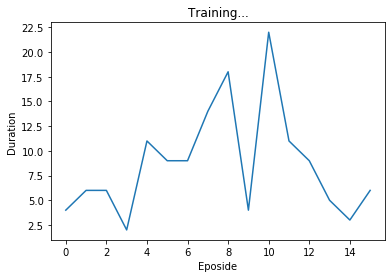

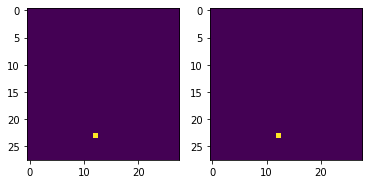

Running Episode 17/100, Epsilon = 0.99


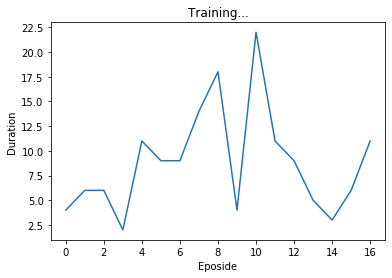

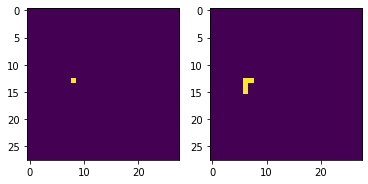

Running Episode 18/100, Epsilon = 0.99


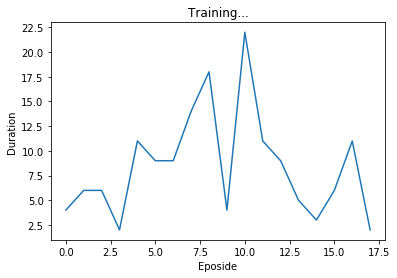

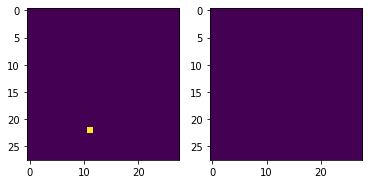

Running Episode 19/100, Epsilon = 0.99


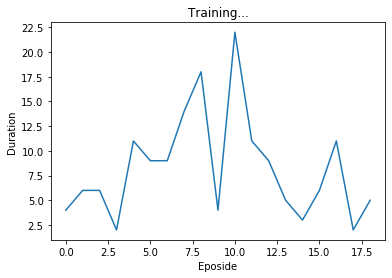

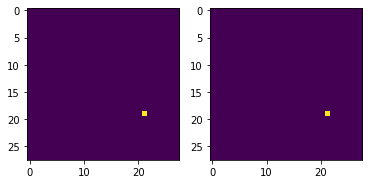

Running Episode 20/100, Epsilon = 0.98


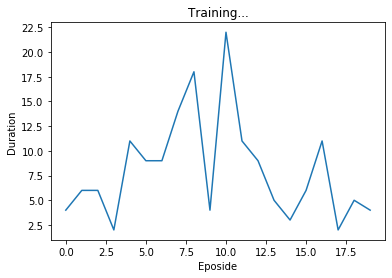

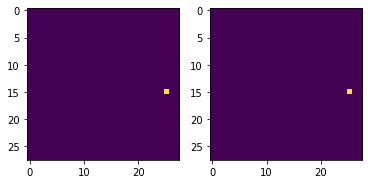

Running Episode 21/100, Epsilon = 0.98


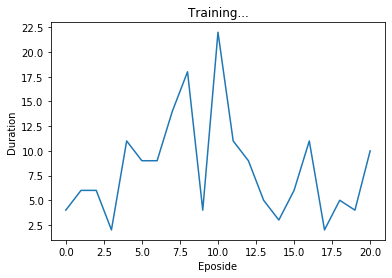

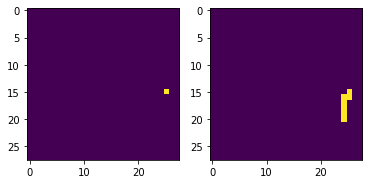

Running Episode 22/100, Epsilon = 0.98


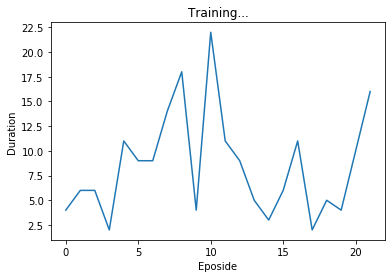

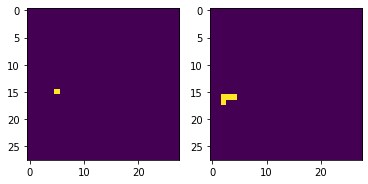

Running Episode 23/100, Epsilon = 0.98


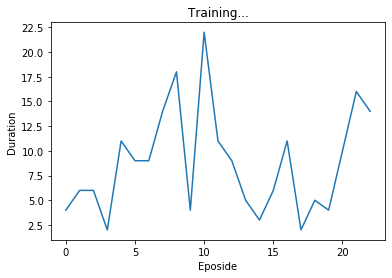

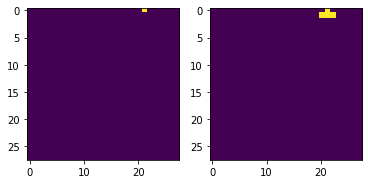

Running Episode 24/100, Epsilon = 0.98


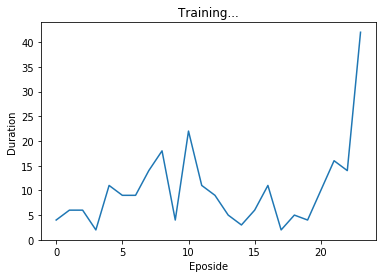

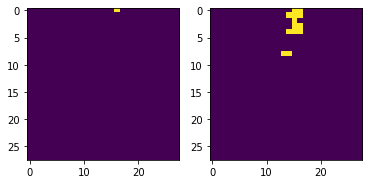

Running Episode 25/100, Epsilon = 0.98


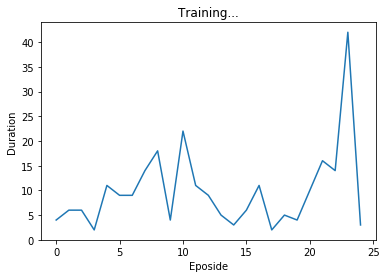

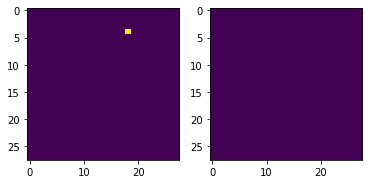

Running Episode 26/100, Epsilon = 0.98


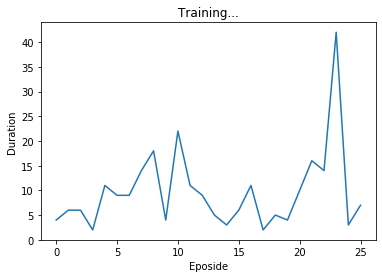

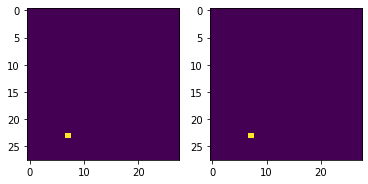

Running Episode 27/100, Epsilon = 0.98


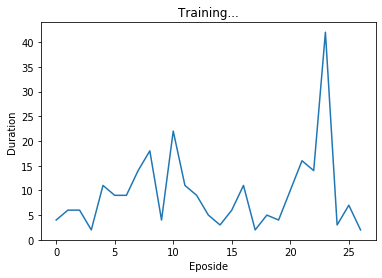

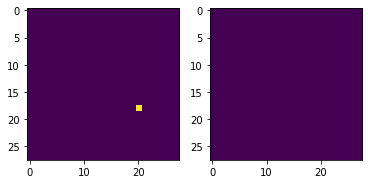

Running Episode 28/100, Epsilon = 0.98


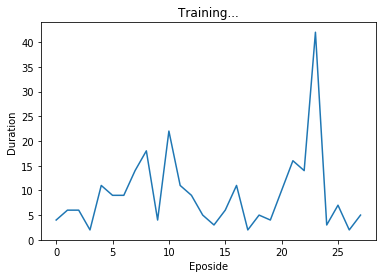

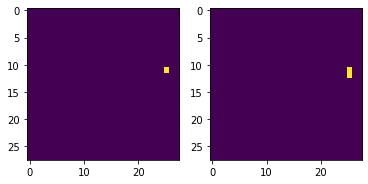

Running Episode 29/100, Epsilon = 0.98


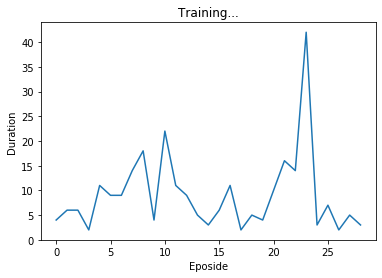

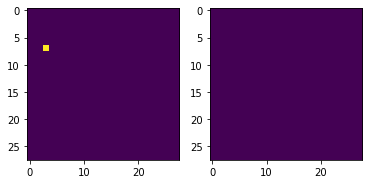

Running Episode 30/100, Epsilon = 0.97


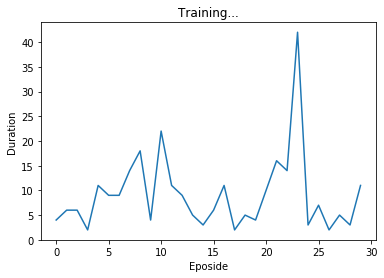

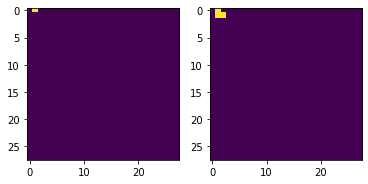

Running Episode 31/100, Epsilon = 0.97


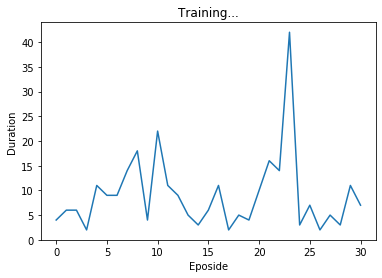

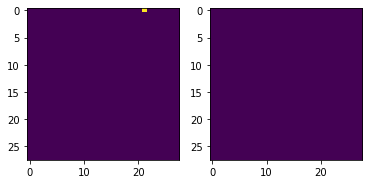

Running Episode 32/100, Epsilon = 0.97


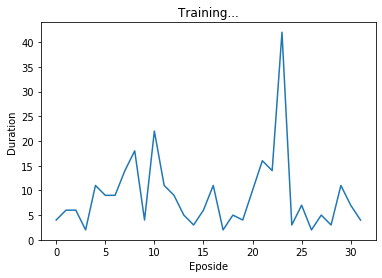

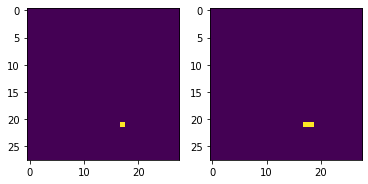

Running Episode 33/100, Epsilon = 0.97


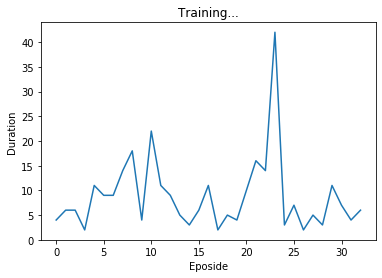

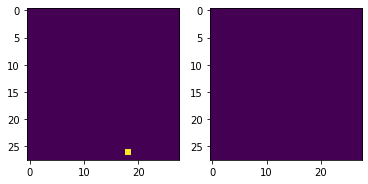

Running Episode 34/100, Epsilon = 0.97


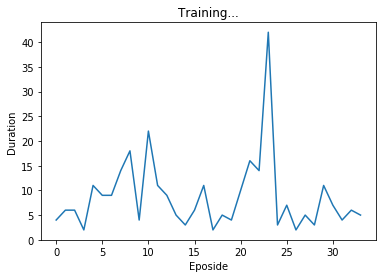

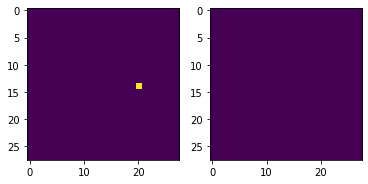

Running Episode 35/100, Epsilon = 0.97


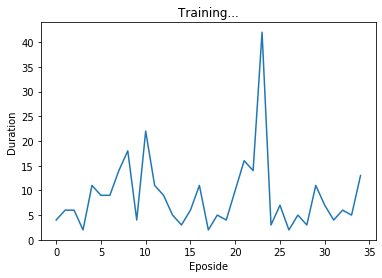

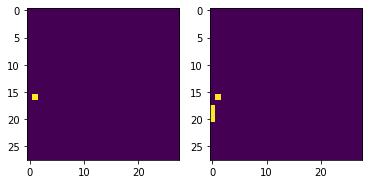

Running Episode 36/100, Epsilon = 0.97


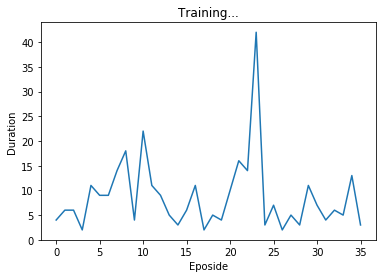

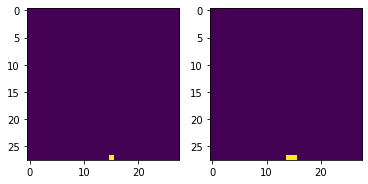

Running Episode 37/100, Epsilon = 0.97


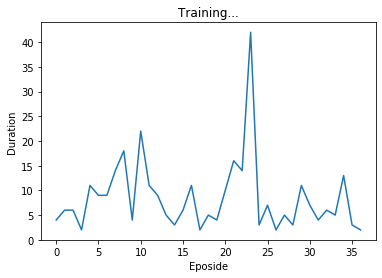

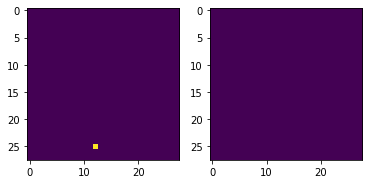

Running Episode 38/100, Epsilon = 0.97


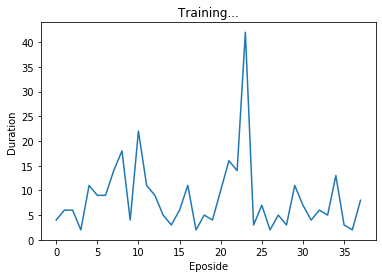

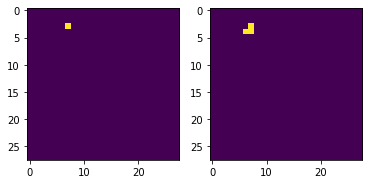

Running Episode 39/100, Epsilon = 0.97


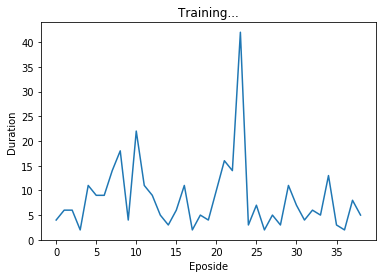

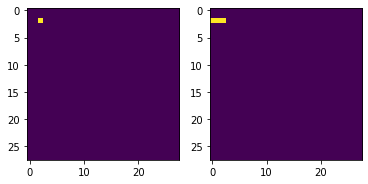

Running Episode 40/100, Epsilon = 0.96


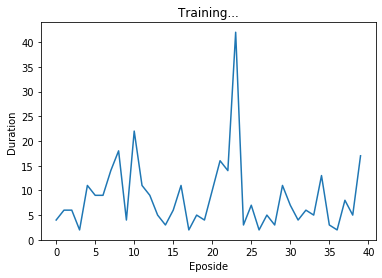

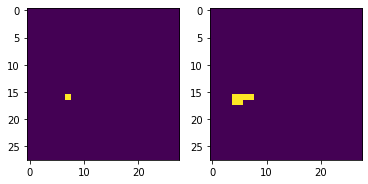

Running Episode 41/100, Epsilon = 0.96


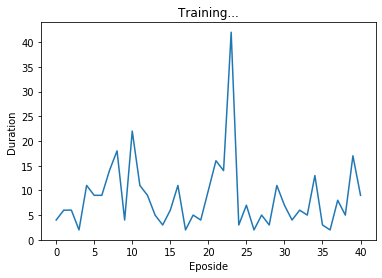

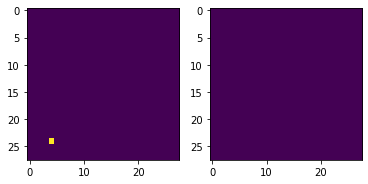

Running Episode 42/100, Epsilon = 0.96


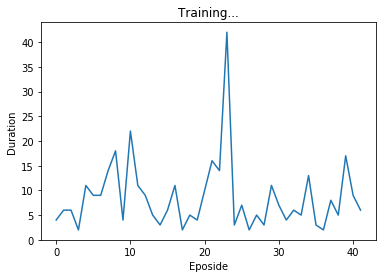

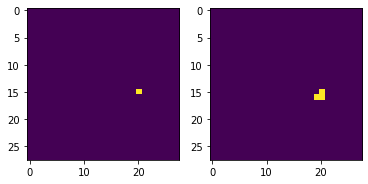

Running Episode 43/100, Epsilon = 0.96


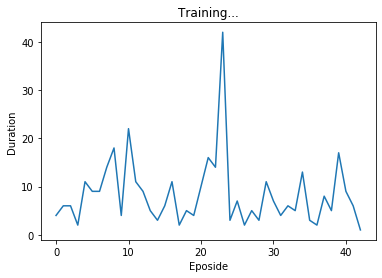

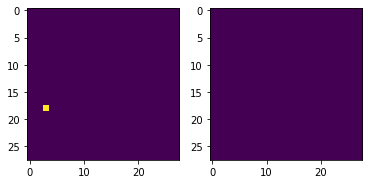

Running Episode 44/100, Epsilon = 0.96


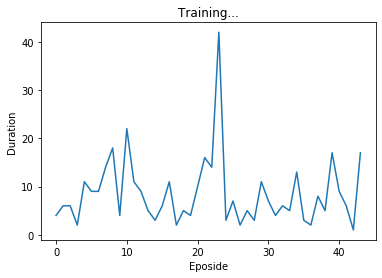

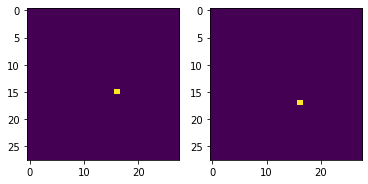

Running Episode 45/100, Epsilon = 0.96


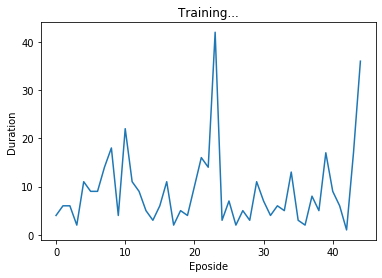

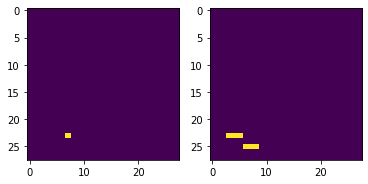

Running Episode 46/100, Epsilon = 0.96


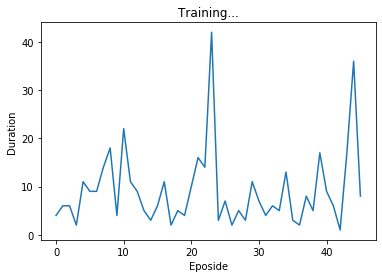

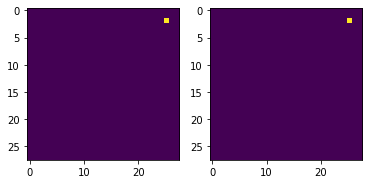

Running Episode 47/100, Epsilon = 0.96


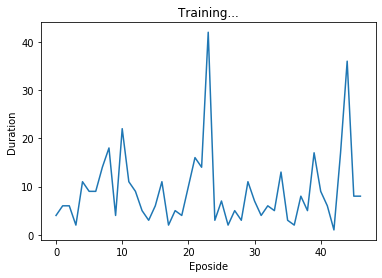

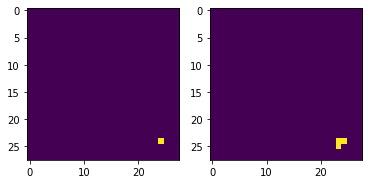

Running Episode 48/100, Epsilon = 0.96


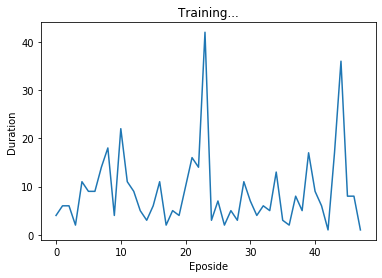

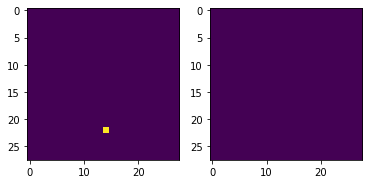

Running Episode 49/100, Epsilon = 0.96


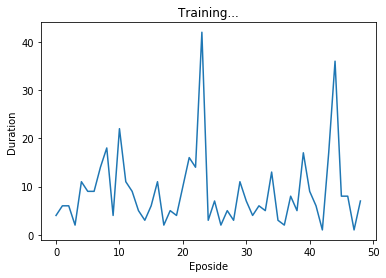

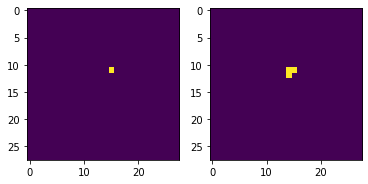

Running Episode 50/100, Epsilon = 0.95


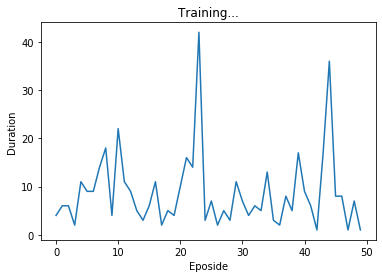

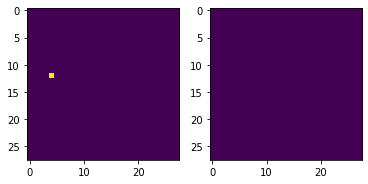

Running Episode 51/100, Epsilon = 0.95


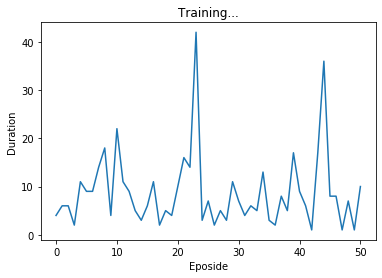

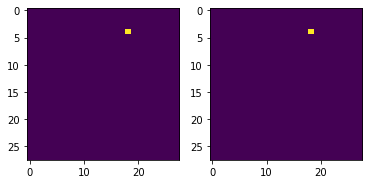

Running Episode 52/100, Epsilon = 0.95


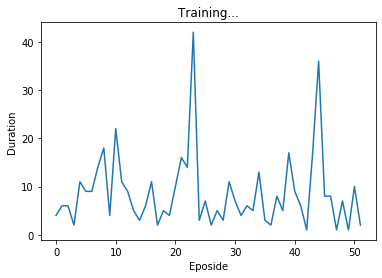

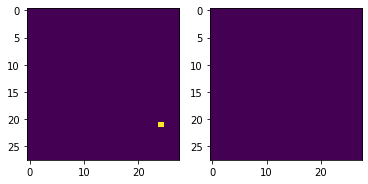

Running Episode 53/100, Epsilon = 0.95


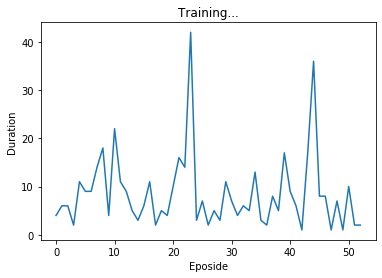

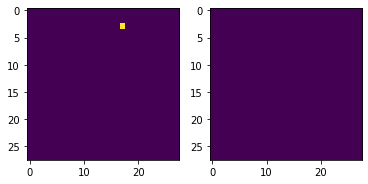

Running Episode 54/100, Epsilon = 0.95


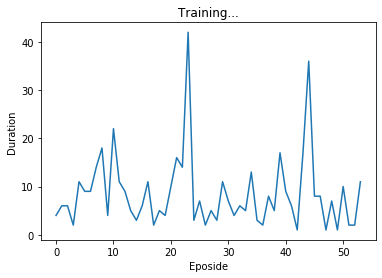

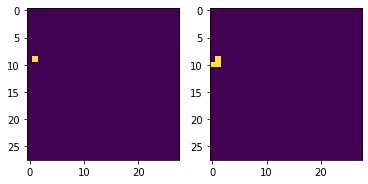

Running Episode 55/100, Epsilon = 0.95


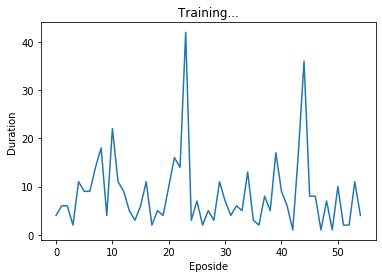

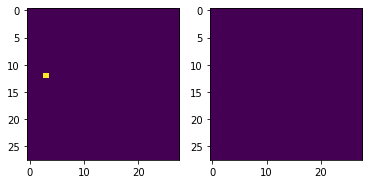

Running Episode 56/100, Epsilon = 0.95


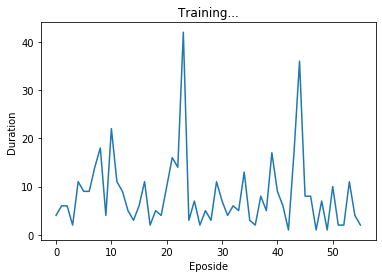

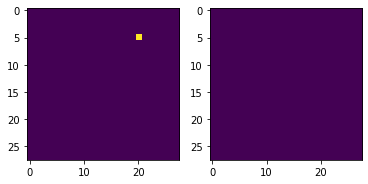

Running Episode 57/100, Epsilon = 0.95


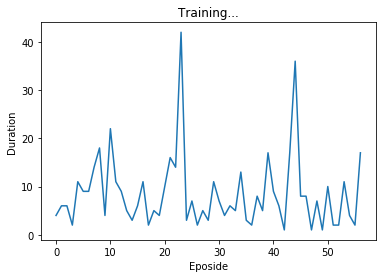

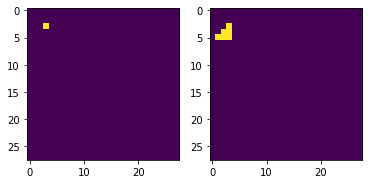

Running Episode 58/100, Epsilon = 0.95


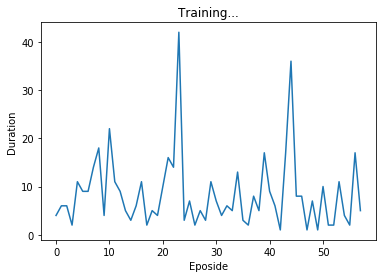

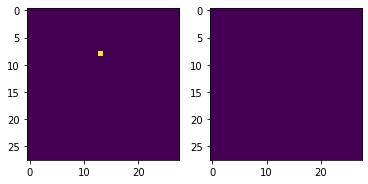

Running Episode 59/100, Epsilon = 0.95


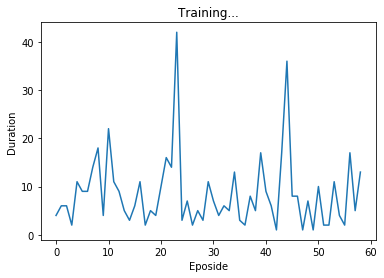

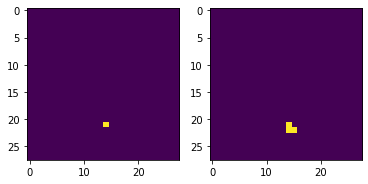

Running Episode 60/100, Epsilon = 0.94


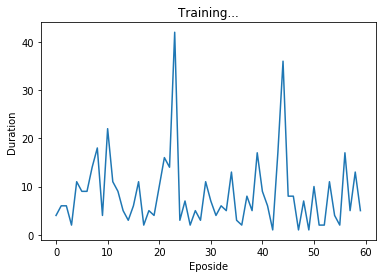

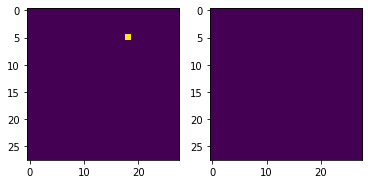

Running Episode 61/100, Epsilon = 0.94


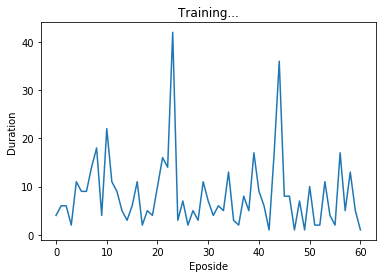

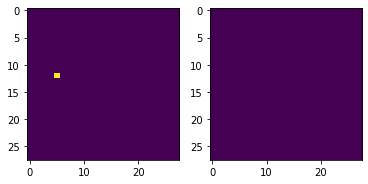

Running Episode 62/100, Epsilon = 0.94


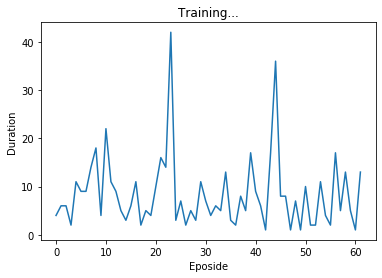

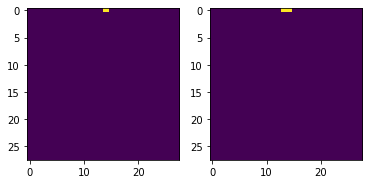

Running Episode 63/100, Epsilon = 0.94


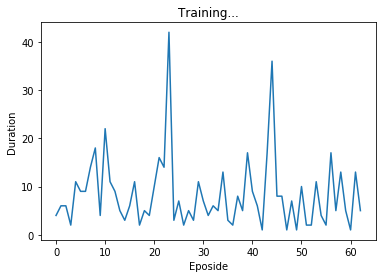

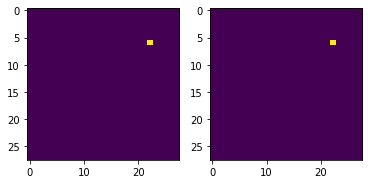

Running Episode 64/100, Epsilon = 0.94


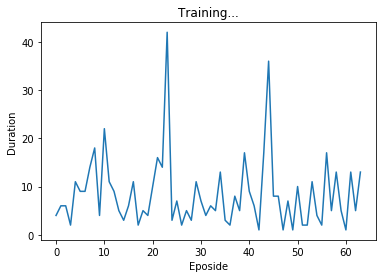

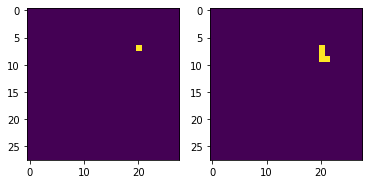

Running Episode 65/100, Epsilon = 0.94


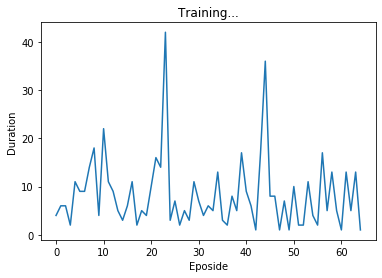

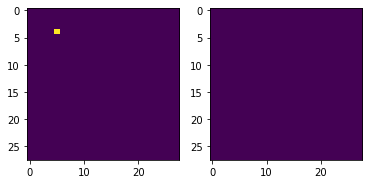

Running Episode 66/100, Epsilon = 0.94


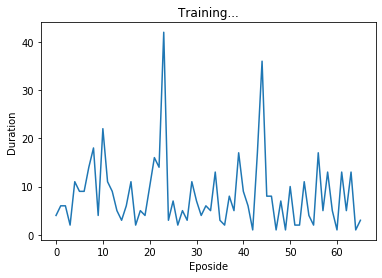

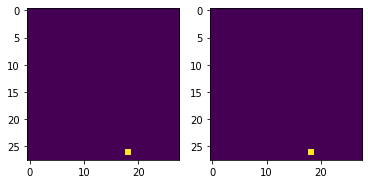

Running Episode 67/100, Epsilon = 0.94


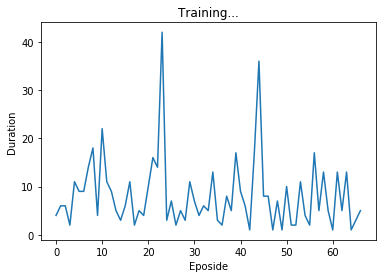

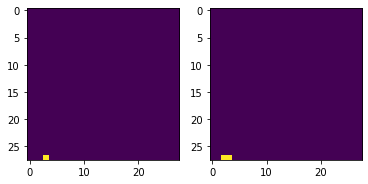

Running Episode 68/100, Epsilon = 0.94


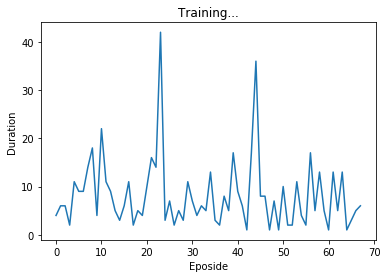

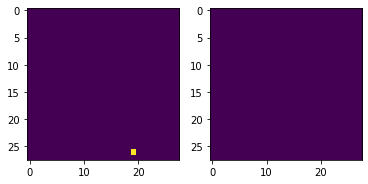

Running Episode 69/100, Epsilon = 0.94


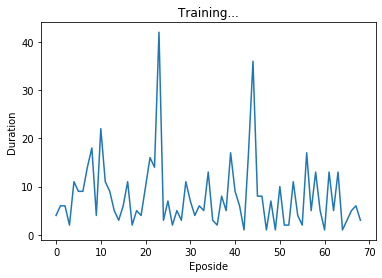

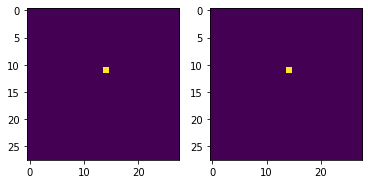

Running Episode 70/100, Epsilon = 0.9299999999999999


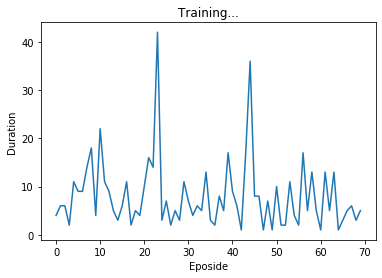

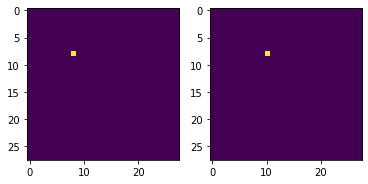

Running Episode 71/100, Epsilon = 0.9299999999999999


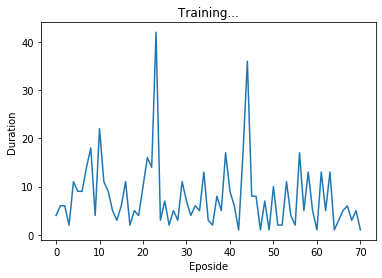

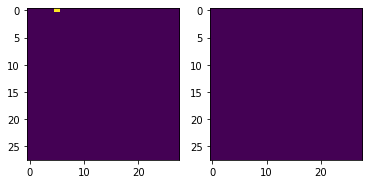

Running Episode 72/100, Epsilon = 0.9299999999999999


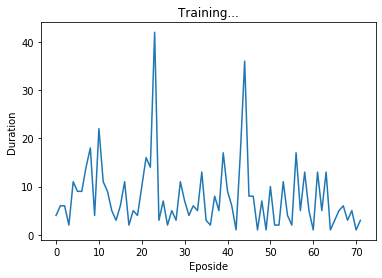

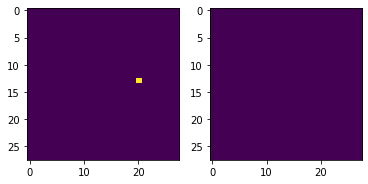

Running Episode 73/100, Epsilon = 0.9299999999999999


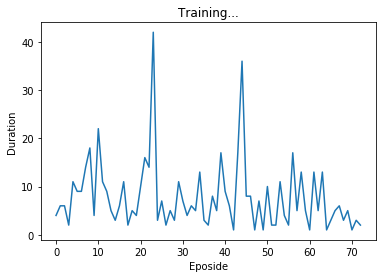

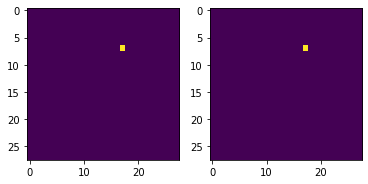

Running Episode 74/100, Epsilon = 0.9299999999999999


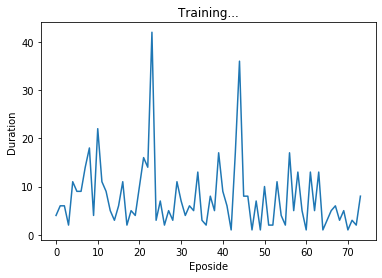

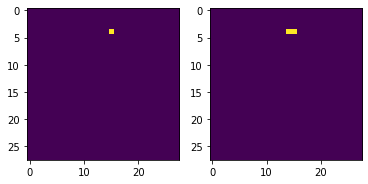

Running Episode 75/100, Epsilon = 0.9299999999999999


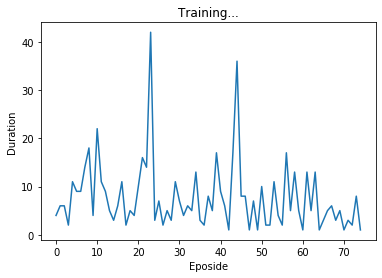

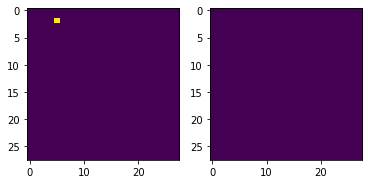

Running Episode 76/100, Epsilon = 0.9299999999999999


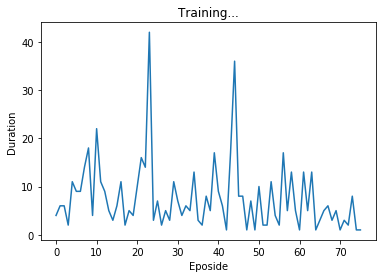

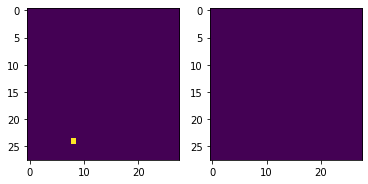

Running Episode 77/100, Epsilon = 0.9299999999999999


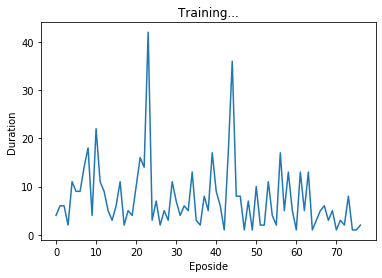

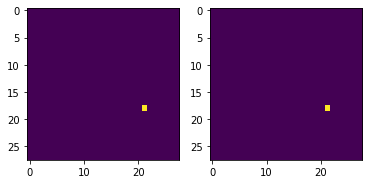

Running Episode 78/100, Epsilon = 0.9299999999999999


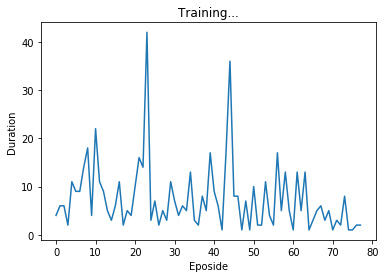

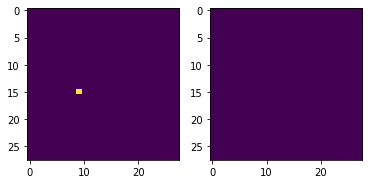

Running Episode 79/100, Epsilon = 0.9299999999999999


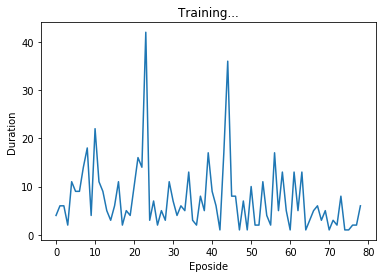

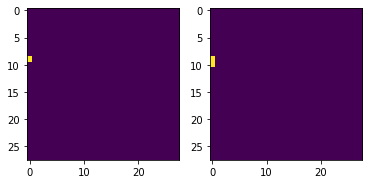

Running Episode 80/100, Epsilon = 0.92


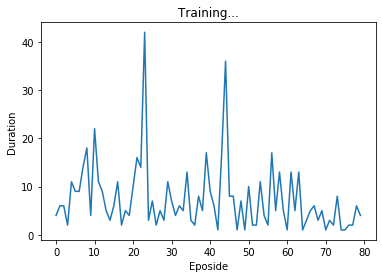

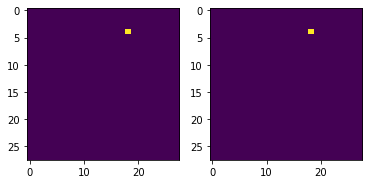

Running Episode 81/100, Epsilon = 0.92


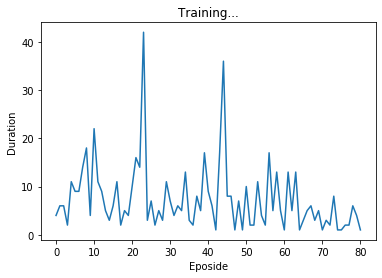

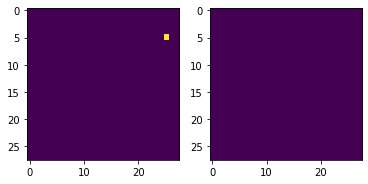

Running Episode 82/100, Epsilon = 0.92


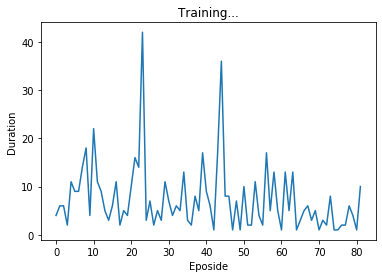

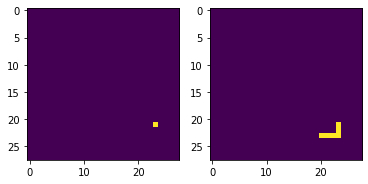

Running Episode 83/100, Epsilon = 0.92


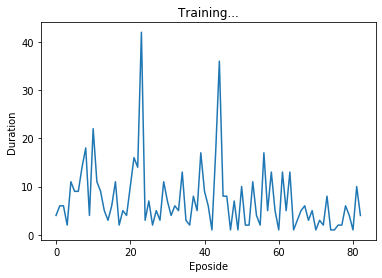

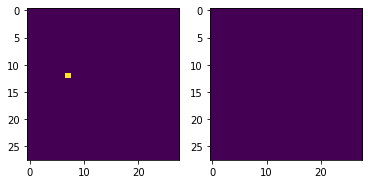

Running Episode 84/100, Epsilon = 0.92


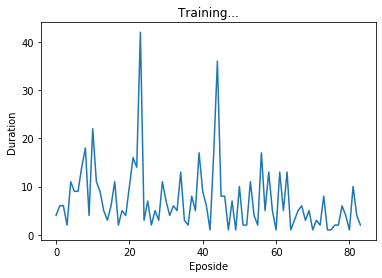

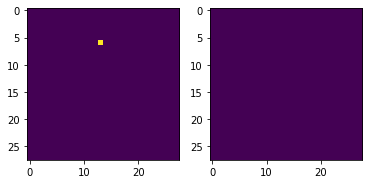

Running Episode 85/100, Epsilon = 0.92


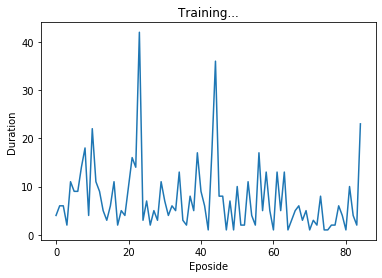

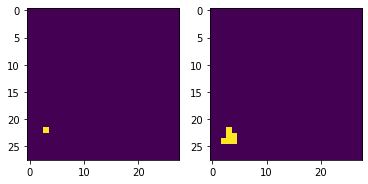

Running Episode 86/100, Epsilon = 0.92


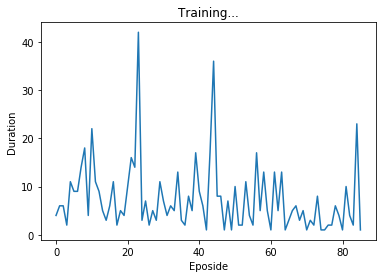

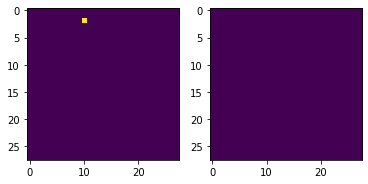

Running Episode 87/100, Epsilon = 0.92


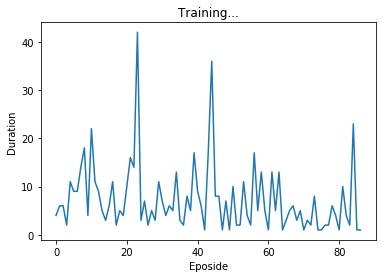

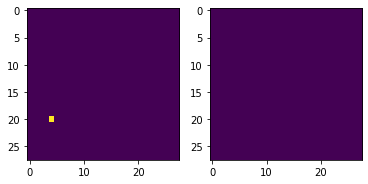

Running Episode 88/100, Epsilon = 0.92


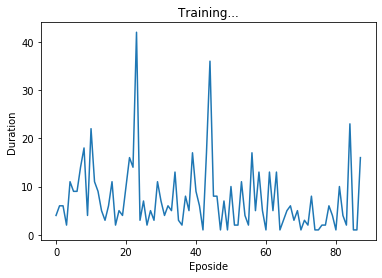

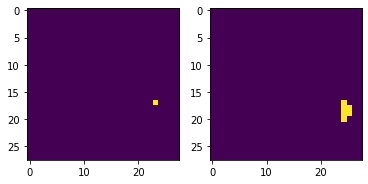

Running Episode 89/100, Epsilon = 0.92


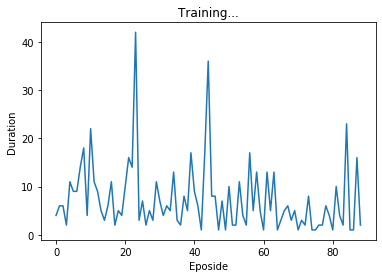

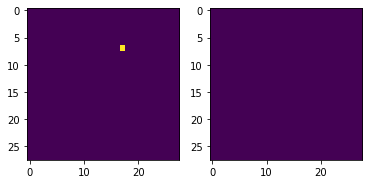

Running Episode 90/100, Epsilon = 0.91


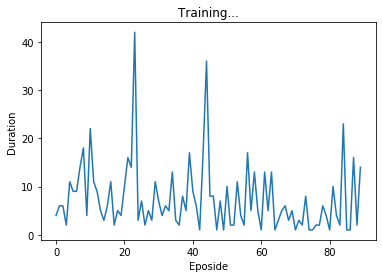

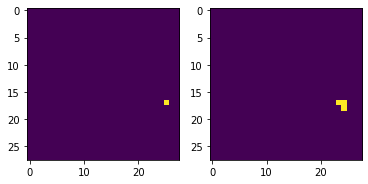

Running Episode 91/100, Epsilon = 0.91


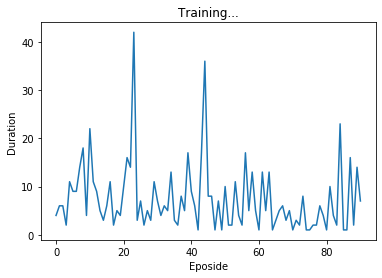

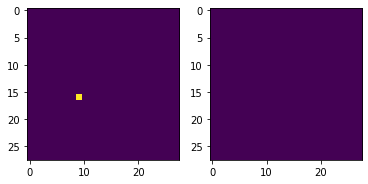

Running Episode 92/100, Epsilon = 0.91


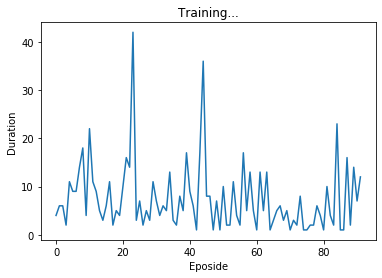

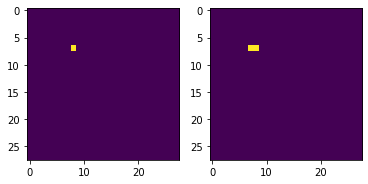

Running Episode 93/100, Epsilon = 0.91


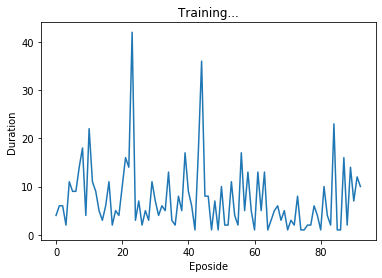

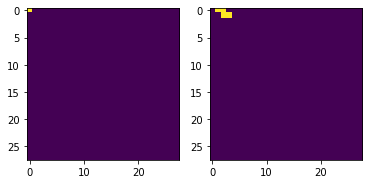

Running Episode 94/100, Epsilon = 0.91


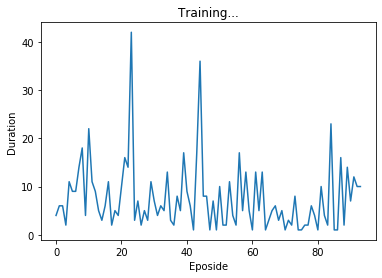

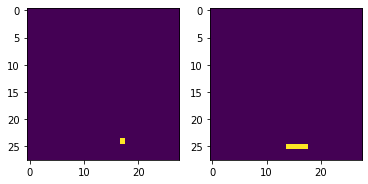

Running Episode 95/100, Epsilon = 0.91


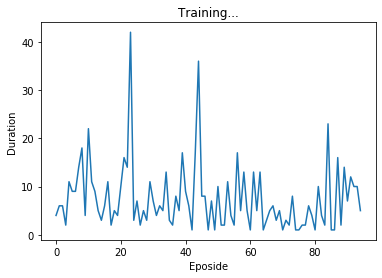

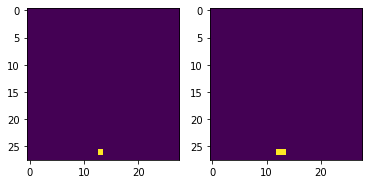

Running Episode 96/100, Epsilon = 0.91


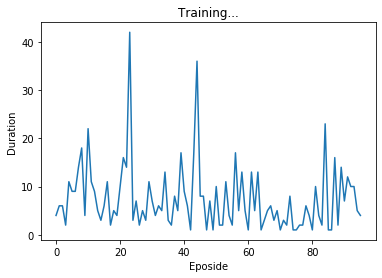

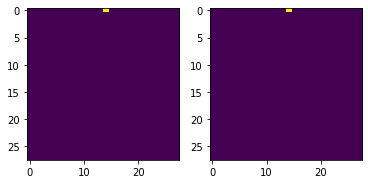

Running Episode 97/100, Epsilon = 0.91


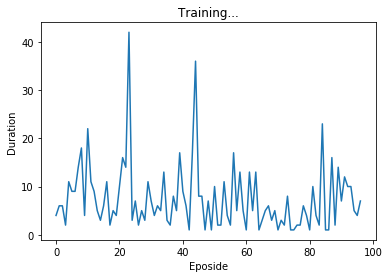

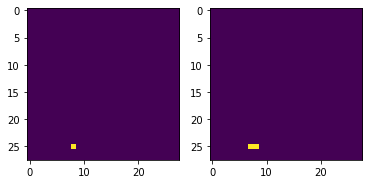

Running Episode 98/100, Epsilon = 0.91


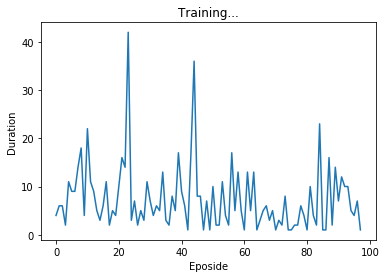

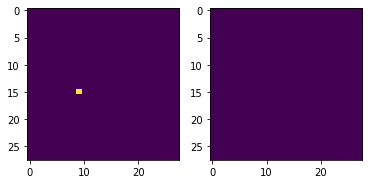

Running Episode 99/100, Epsilon = 0.91


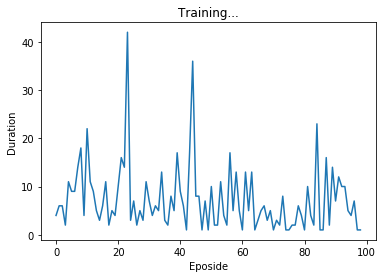

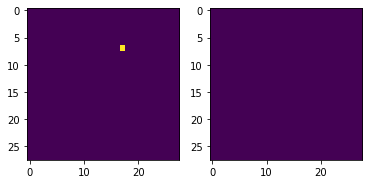

Running Episode 100/100, Epsilon = 0.9


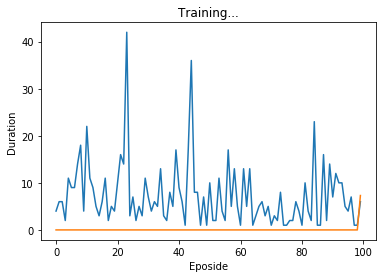

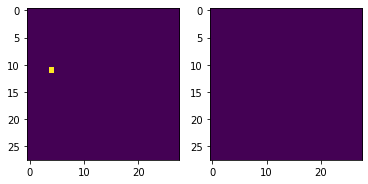

Complete


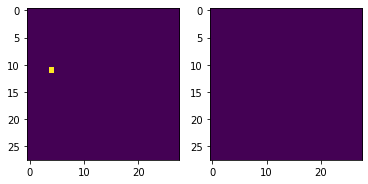

In [18]:
num_episode = 100
eps_threshold = EPS_START
for i_episode in range(1, num_episode+1):
    eps_threshold = max(EPS_END, EPS_START - (i_episode // 10) * 0.01)
    print("Running Episode {}/{}, Epsilon = {}".format(i_episode, num_episode, eps_threshold))
    # Initialize the environment and state
    state = env.reset()
    
    for t in count():
        # Select and perform an action
        action = select_action(state, eps_threshold)
        next_state, reward, done = env.step(action.item())
        reward = torch.tensor(reward, device=device)
        if done:
            next_state = None
        
        # Store the transition in memory
        memory.push(state, action, next_state, reward)
        
        # Move to the next state
        state = next_state
        
        # Perform one step of optimization (on target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            env.render()
            break
    
    # Update the target network by copying weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
        
print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()